In [375]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits
from matplotlib.colors import LogNorm
from scipy.optimize import newton, curve_fit

In [376]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    files = [file[0].data for file in files]
    return np.array(files)
    
def lazy_load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    return files

def num_sd(arr):
    
    return np.abs(arr - arr.mean()) / arr.std()
    
def apply_mask(arr, mask):
    
    arr = arr.astype(np.float32)
    
    arr *= mask
    arr[1:-1, 1:-1] += ~mask[1:-1, 1:-1] * 0.25 * \
                      (arr[:-2, 1:-1] + arr[2:, 1:-1] +
                       arr[1:-1, :-2] + arr[1:-1, 2:])
    return arr

In [377]:
reduced_star = load_plz("data/*star_re*")[0]

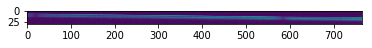

In [378]:
cropped = reduced_star[15:45,:]
plt.imshow(cropped)

In [379]:
temp = 11361
temp_err = 66 
h = 6.626e-34
c = 3*10**8
k = 1.381e-23
def blackbody(Lambda, T):
    return 2*h*c**2/Lambda**5/(np.exp(h*c/(Lambda*k*T))-1)    

In [380]:
attempt0 = np.mean(cropped,axis=0)

for i in range(len(attempt0)):
    if attempt0[i] == np.min(attempt0):
        H_abs_loc = i
    if attempt0[i] == np.min(attempt0[500:650]):
        H_abs2 = i
ang_per_pixel = (H_abs2 - H_abs_loc)/520
shift1 = (4341 - H_abs_loc*ang_per_pixel)        #lower level calibrations 
shift2 = (4861 - H_abs2*ang_per_pixel)           #to get an idea of the right answer
ang_per_pixel = (H_abs2 - H_abs_loc)/520
shift = (shift1 + shift2) / 2
x = np.linspace(shift,(shift+len(attempt0)), 765)

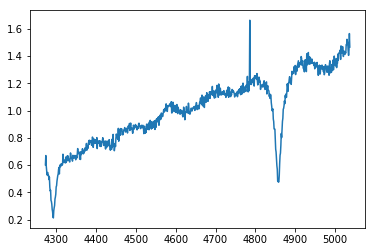

In [381]:
star_spec = attempt0/blackbody(x*1e-10,temp) #divide out some good blackbody stuff
star_mean = np.mean(star_spec)
star_spec = star_spec/star_mean
plt.plot(x,star_spec)

#plt.plot(x, blackbody(x*1e-10,temp)/1e37)

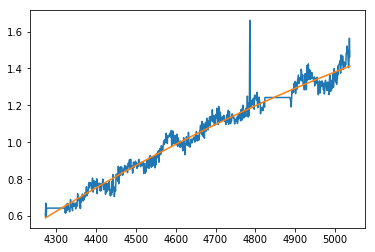

In [382]:
for i in range(len(star_spec)):
    if 2<i<50 :
        star_spec[i]=(star_spec[1]+star_spec[50])/2
    if 550<i<615:
        star_spec[i]=(star_spec[549]+star_spec[620])/2
N = 2
data_fitfunc = np.poly1d(np.polyfit(x,star_spec,N))
plt.plot(x,star_spec)
plt.plot(x,data_fitfunc(x))

In [383]:
nebulae = sorted(glob.glob("data/nebula_reduced.fits"))
nebulae = list(map(fits.open, nebulae[:]))
nebulae = (nebulae[0][0].data)

flat_field = sorted(glob.glob('data/median_flat*'))
flat_field = list(map(fits.open, flat_field[:]))
flat_field = flat_field[0][0].data
flat_field = flat_field[15:80,:]
flat_median = np.median(flat_field,axis=0)

dark_field = sorted(glob.glob('data/median_dark*'))
dark_field = list(map(fits.open, dark_field[:]))
dark_field = dark_field[0][0].data
dark_field = dark_field[15:55,:]
dark_median = np.median(dark_field,axis=0)

nebulae = nebulae[15:80, :]
nebulae = nebulae*flat_field
np.mean(np.median(nebulae[0:40,:], axis = 0))

61.82941

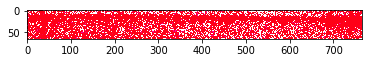

In [384]:
plt.imshow(nebulae, cmap='hsv',norm=LogNorm(vmin=.0000001, vmax=2.5));

In [385]:
counts = (np.median(nebulae[0:40,:], axis = 0))
flat_median_norm = flat_median/np.mean(flat_median)
counts = counts/flat_median_norm

counts1 = (np.median(nebulae[40:65,:], axis = 0))
flat_median_norm = flat_median/np.mean(flat_median)
sky_mean = counts1/flat_median_norm

N = 5

error = np.sqrt(counts)/np.sqrt(N)
counts = counts - sky_mean

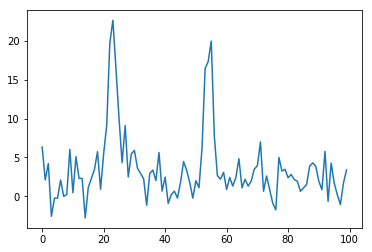

In [386]:
neb_norm = counts/data_fitfunc(x)

mean  = neb_norm
error = (error/data_fitfunc(x))


std_dev = np.std(neb_norm, axis = 0)
plt.plot(np.arange(0,100),mean[400:500])

In [387]:
def peaks(data,epi):
    indices, = np.nonzero(data > epi)
    jumps = (indices[1:] - indices[:-1]) != 1
    # print([(i, jump) for i, jump in zip(indices, jumps)])

    lows = list(indices[1:][jumps])
    highs = list(indices[:-1][jumps])

    lows = [indices[1:].min()-2] + lows
    highs = highs + [indices.max()+2]

    indices = [data[lo:hi+1].argmax() + lo if lo != hi else lo
               for lo, hi in zip(lows, highs)]

    indices = np.array(indices)
    return indices,np.array(lows),np.array(highs)

In [388]:
indices,lows,highs = [],[],[]
epi = 17
indices,lows,highs = peaks(mean,epi)

In [389]:
theory = np.array([4341,4363,4686,4711,4740,4861,4959,5007])
m, b = np.polyfit(indices,theory,1)
#obtain a better estimate for the dispersion and for the shifting needed
# m is the better 'ang_per_pix' and b is the better 'shift'

In [390]:
def descend_from_peak(i, direction=1):
    
    peak_loc = indices[i]
    
    if direction > 0: j = max(highs[i], peak_loc)
    else: j = min(lows[i], peak_loc)
    
    while True:
        
        delta = mean[j+1] - 2*mean[j] + mean[j-1]
        sign = delta / np.abs(delta)
        if sign > 0:
            return j
        j += direction

In [391]:
def gaussian(x, *params):
    """
    Models a Gaussian distribution. To convert to a function that only takes the independent variable,
    use fixed_params.
    :param x: Independent variable.
    :param params: The parameters of the distribution, in the order amplitude, variance (sigma), and mean (mu).
    :return: The value of the distribution at x.
    """

    A, var, mu = params
    return A / np.sqrt(2 * np.pi * var) * np.exp(-(x - mu)**2 / (2 * var)) 

def gaussian_fit(x, y, err_y=None):
    """
    Fits a Gaussian distribution to the input data.
    :param x: The sequence of x values for the dataset.
    :param y: The sequence of y values for the dataset.
    :param err_x: The errors in the x values.
    :param err_y: The errors in the y values.
    :return: A two dimensional array, containing first the values of the parameters and then the corresponding errors.
        The parameters are amplitude, variance and mean (mu) respectively.
    """
    
    mu = np.mean(x)
    var = np.var(x)
    A = max(y) * np.sqrt(2 * np.pi * var)

    
    p0 = A, var, mu

    # Return the correct fit based on the input errors
    res = curve_fit(gaussian, x, y, p0, err_y)
    return res[0], res[1]

/home/jmichel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


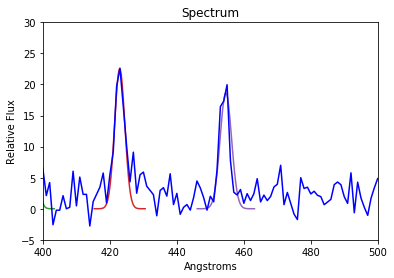

In [392]:
peak_sums = []
x1 = np.arange(0, len(mean))*m + b
plt.title("Spectrum")
plt.xlabel('Angstroms')
plt.ylabel('Relative Flux');
#plt.savefig("camel_line.png", dpi=600);
#print(len(highs))
for i in range(len(highs)):
    new_high = descend_from_peak(i,direction=1)
    new_low  = descend_from_peak(i,direction=-1)
         

    x1 = np.arange(new_low, new_high+1)
    par, par_err = gaussian_fit(x1, mean[new_low:new_high+1])
    
    #local_mean = 0 #for the meantime
    A, var, mu= par
    
    #second argon is messy lets make it wider wihtout modifying 
    if i == 4:
        var += 2
        A = 80
        par = A, var, mu
    
    sigma = np.sqrt(var)
    x1 = np.linspace(mu - 5*sigma, mu + 5*sigma)
    plt.plot(x1, gaussian(x1, *par))

    lowz = np.mean(mean[new_low-10:new_low])
    highz = np.mean(mean[new_high:new_high+10])
    
    local_mean = (lowz+highz)/2
    A,var,mu = par
    
    peak_sums.append([np.trapz(gaussian(x1, *par)+local_mean,x1),indices[i]*m+b] )
    
#make nice plot
plt.plot(np.arange(0, len(mean)),mean,color='blue')
plt.xlim(400,500)
plt.ylim(-5, 30);


In [393]:
np.savetxt('emission_line_strengths.csv', peak_sums, delimiter=',')

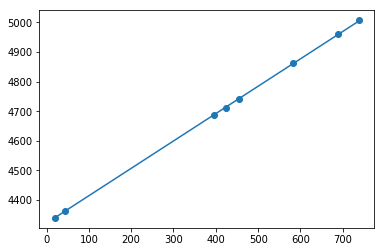

In [394]:
plt.scatter(indices,theory)
y = np.poly1d(np.polyfit(indices,theory,1))
plt.plot(indices,y(indices))

In [395]:
error = error[indices]

oxygen_ratio = (peak_sums[6][0] + peak_sums[7][0]) / (peak_sums[1][0]) 
n_e = 1e3
high_oxy     = (peak_sums[6][0] + error[6] + peak_sums[7][0] + error[7]) / (peak_sums[1][0] - error[1]) 
low_oxy     = (peak_sums[6][0] - error[6] + peak_sums[7][0] - error[7]) / (peak_sums[1][0] + error[1])
oxygen_error = np.sqrt((error[6]/peak_sums[1][0])**2 + (error[7]/peak_sums[1][0])**2 + (error[1]*(peak_sums[6][0] + peak_sums[7][0])/ (peak_sums[1][0])**2))
oxygen_error

1.4040909754547986

In [396]:
oxygen_ratio, high_oxy, low_oxy

(108.00257149751796, 110.18160294928428, 105.90093078279311)

In [397]:
def func(T, oxygen_ratio):
    
    return 7.9*np.exp(3.29e4/T) / (1+4.5e-4*n_e*T**(-0.5)) - oxygen_ratio

def funcprime(T):
    
    return 7.9*np.exp(3.29e4/T) / (1+4.5e-4*n_e*T**(-0.5)) * 3.29e4 / T**2 - \
           7.9*np.exp(3.29e4/T) / (1+4.5e-4*n_e*T**(-0.5))**2 * 4.5e-4*n_e*(-0.5)*T**(-1.5)

Temperature = newton(func,12500, args=(oxygen_ratio,))
Temp_low   = newton(func, 13000, args=(high_oxy,))
Temp_high    = newton(func, 10000, args=(low_oxy,))
                     
T_error = 1 / funcprime(Temperature) * oxygen_error
print("Measured temperature is", Temperature, "+", Temperature-Temp_low, "or", Temperature-Temp_high)
print((12500-Temperature)/(Temperature-Temp_low))

Measured temperature is 12560.610492284748 + 95.13480392987185 or -95.02010001296003
-0.637101142599997


In [398]:
argon_ratio = ((peak_sums[3][0] / peak_sums[4][0]))
argon_up    = (peak_sums[3][0] + error[3]) / (peak_sums[4][0] - error[4])
argon_down  = (peak_sums[3][0] - error[3]) / (peak_sums[4][0] + error[4])
argon_error = np.sqrt((error[3] / peak_sums[4][0])**2 + (peak_sums[3][0]*error[4]/(peak_sums[4][0])**2)**2)
print("Measured argon ratio:",argon_ratio,'+', argon_up-argon_ratio ,'-' ,argon_ratio-argon_down)

Measured argon ratio: 1.0298197318649425 + 0.03196871981736571 - 0.031013017472536486


In [399]:
print("Calculated Temperature: ", round(Temperature,3),'+-',Temperature-Temp_low, " Literature value: 12500")
print('N_e calculated from ratio and graph: ~2.8e3 +- .3 Literature Value: 3e3')

Calculated Temperature:  12560.61 +- 95.13480392987185  Literature value: 12500
N_e calculated from ratio and graph: ~2.8e3 +- .3 Literature Value: 3e3


Page 7 of https://arxiv.org/pdf/astro-ph/0003410.pdf gives N_e of NGC 7662

Error in progress

In [400]:
Temperature

12560.610492284748

In [401]:
peak_sums, error

([[585.9116872667424, 4339.619209001457],
  [243.98422570459033, 4361.807527257009],
  [358.94252615381134, 4687.236195005098],
  [139.98130239595895, 4713.122566303242],
  [135.9279668709213, 4742.706990643977],
  [1282.732445177641, 4861.0446880069185],
  [6314.976151249736, 4958.118580374957],
  [20035.94762967684, 5004.344243407356]],
 array([ 7.63500277,  4.41101732,  3.89754367,  2.15538903,  2.06260866,
         7.57413292, 16.39047134, 29.24587161]))